## Revenue and Customer Numbers Forecasting

### Introduction

In this study, revenue and customer data is provided from two retail shops in 2022. The goal is to estimate the revenue and the new number of customers in those shops during 2023. Furthermore, The data is used to forecast the same metrics for two new shops which are planned to be launched during in March and July 2023.

### Assumptions and Approach

**Assumptions:**
- Both shops started in 01.01.2022. Therefore, customer IDs that appear for the first time in the dataset are considered new customers
- That the growth rates in monthly revenue and new customers for both shops will continue into 2023 at the same rate as 2022
- To simplify the analysis, we assume there are no boundaries for continuous growth (such as resources and capacity) 
- The planned new shops in 2023 will have both identical growth behavior to the regression average of shop 1 and 2 in 2022
- For simplification, all data points will be included in regression calculations and no data points will be considered an outlier

**Approach:**
- The forecasting is performed arithmetically, where growth trends of revenue and customer numbers are tracked in 2022 and extrapolated to 2023 
- Regression will be based on monthly metrics (revenue and new customers) of the shop, regardless the number of orders in each month

### Exploratory data analysis

In [1]:
import warnings

# Suppress the SciPy version warning
warnings.filterwarnings("ignore", message="A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
#converting the csvs into dataframes
orders_df = pd.read_csv('dataset/case_study_orders.csv')
revenues_df = pd.read_csv('dataset/case_study_revenues.csv')

In [4]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11015 entries, 0 to 11014
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   order_id     11015 non-null  object
 1   seller_id    11015 non-null  object
 2   customer_id  11015 non-null  int64 
 3   shop_id      11015 non-null  int64 
 4   order_date   11015 non-null  object
dtypes: int64(2), object(3)
memory usage: 430.4+ KB


In [5]:
#formatting the order dates into datetime format
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])

In [6]:
revenues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11015 entries, 0 to 11014
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   order_id  11015 non-null  object 
 1   revenues  10902 non-null  float64
dtypes: float64(1), object(1)
memory usage: 172.2+ KB


In [7]:
orders_df.head()

,order_id,seller_id,customer_id,shop_id,order_date
0,0004df0d-3df6-42be-9d68-b646a42a44bb,c7402157-ae44-45cc-b6a7-b348d5dbd417,158184,2,2022-12-22
1,000a978e-f134-47b3-ab9e-4f56084be38e,3ca4793d-065e-4112-b023-d1122a2a4b44,112887,2,2022-06-02
2,000c1615-0980-4933-9ad1-6f34bb5e188e,c7402157-ae44-45cc-b6a7-b348d5dbd417,141451,2,2022-10-18
3,000d8c91-e6a8-4404-bf8b-4951ed8ca1f2,2ea0ca2a-77fc-4447-b57c-62a6cb4d75a1,37516,1,2022-01-06
4,0015acc2-484c-491a-b455-0963835a31dd,ed1a5b13-3dc5-4212-b989-f59258b4410e,141833,2,2022-10-14


In [8]:
revenues_df.head()

,order_id,revenues
0,68339e8c-c708-4042-ba21-263838e0487b,NaN
1,270bd629-028b-45b2-86a1-af8de97a7fd0,54.17
2,85c0b7cf-6e50-4683-88c4-9d6ea30f6500,20.67
3,4333637e-b13a-41b8-a0b6-d43ce4c7c761,35.69
4,e526a6ac-eaf4-47bd-bead-1332fe3444e4,150.77


In [9]:
#start and end date
orders_df['order_date'].min(), orders_df['order_date'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

*The data is provided for the period between 01.01.2022 to 31.12.2022*

In [10]:
#orders unique values
orders_df.nunique()

order_id       11015
seller_id          6
customer_id     3977
shop_id            2
order_date       294
dtype: int64

In [11]:
#checking for null values
revenues_df.isnull().sum()

order_id      0
revenues    113
dtype: int64

*There are 113 orders with null or missing revenue*

In [12]:
#checking if the the values of key columns of both dataframes are identical
orders_df_sorted = orders_df.sort_values(by='order_id').reset_index(drop=True)
revenues_df_sorted = revenues_df.sort_values(by='order_id').reset_index(drop=True)
orders_df_sorted['order_id'].equals(revenues_df_sorted['order_id'])

True

In [13]:
#since the key columns are identical, we can perform an inner merge
merged_df = pd.merge(orders_df_sorted, revenues_df_sorted, on='order_id')
merged_df.sort_values('order_date', ascending=True, inplace=True)
merged_df.head()

,order_id,seller_id,customer_id,shop_id,order_date,revenues
3322,4bf4b2c0-6735-459f-a931-29474d0b1e5e,098431c3-1301-456e-9171-0026d20a3d62,22546,1,2022-01-01,20.68
4223,610b31be-8063-4a41-97d2-6cfe487d7640,098431c3-1301-456e-9171-0026d20a3d62,28430,1,2022-01-01,24.11
2120,2f9dd690-d894-4ffb-8bcb-ee7157568989,098431c3-1301-456e-9171-0026d20a3d62,29160,1,2022-01-01,140.10
2951,4333637e-b13a-41b8-a0b6-d43ce4c7c761,098431c3-1301-456e-9171-0026d20a3d62,18111,1,2022-01-01,35.69
10557,f4e6b8d5-c7ff-4241-a3e1-4c384b063fe4,098431c3-1301-456e-9171-0026d20a3d62,36951,1,2022-01-01,52.83


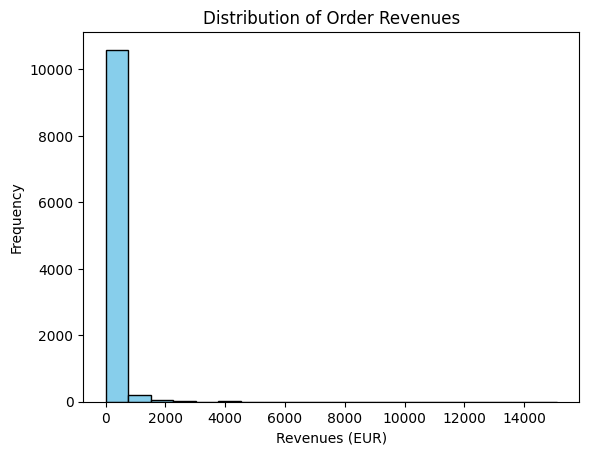

In [14]:
#checking the distribution of single order revenue
plt.hist(merged_df['revenues'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Order Revenues')
plt.xlabel('Revenues (EUR)')
plt.ylabel('Frequency')
plt.show()

*Note: The majority of orders are orders had less than 1000 EUR revenue*

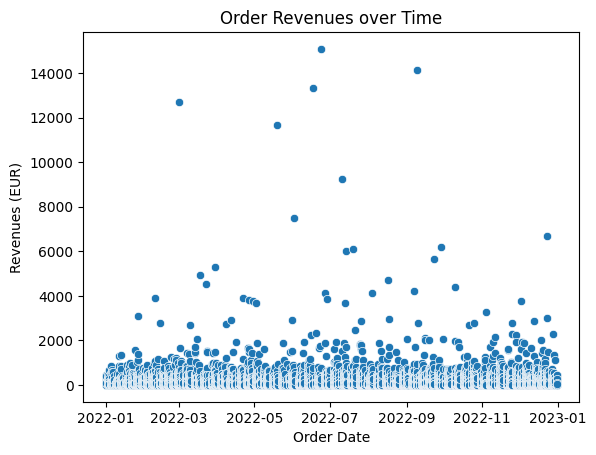

In [15]:
#checking the seasonality of highly expensive orders*
sns.scatterplot(x='order_date', y='revenues', data=merged_df)
plt.title('Order Revenues over Time')
plt.xlabel('Order Date')
plt.ylabel('Revenues (EUR)')
plt.show()

*Note: No observable temporal pattern for highly expensive orders*

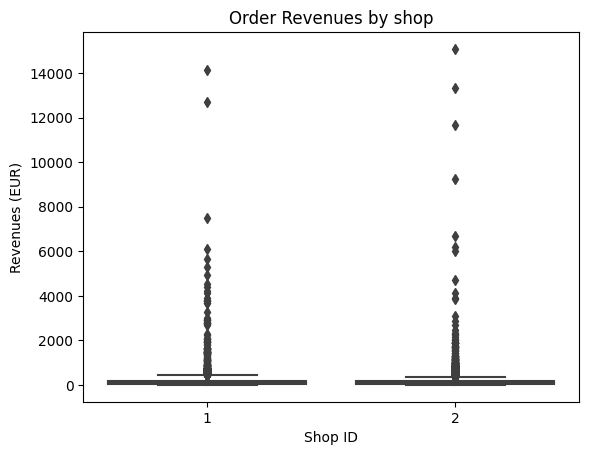

In [16]:
#revenue distribution for each shop
sns.boxplot(x='shop_id', y='revenues', data=merged_df)
plt.title('Order Revenues by shop')
plt.xlabel('Shop ID')
plt.ylabel('Revenues (EUR)')
plt.show()

*Note: Both shops exhibit similar revenue distribution patterns*

### Monthly Metrics

In [17]:
# calculating monthly totaly and average revenue
merged_df['month'] = merged_df['order_date'].dt.month
monthly_revenue_df = merged_df.groupby(['shop_id', 'month']).agg(revenue_per_month=('revenues','sum')).reset_index().round()
monthly_revenue_df.head()

,shop_id,month,revenue_per_month
0,1,1,49252.0
1,1,2,67169.0
2,1,3,90366.0
3,1,4,87678.0
4,1,5,63757.0


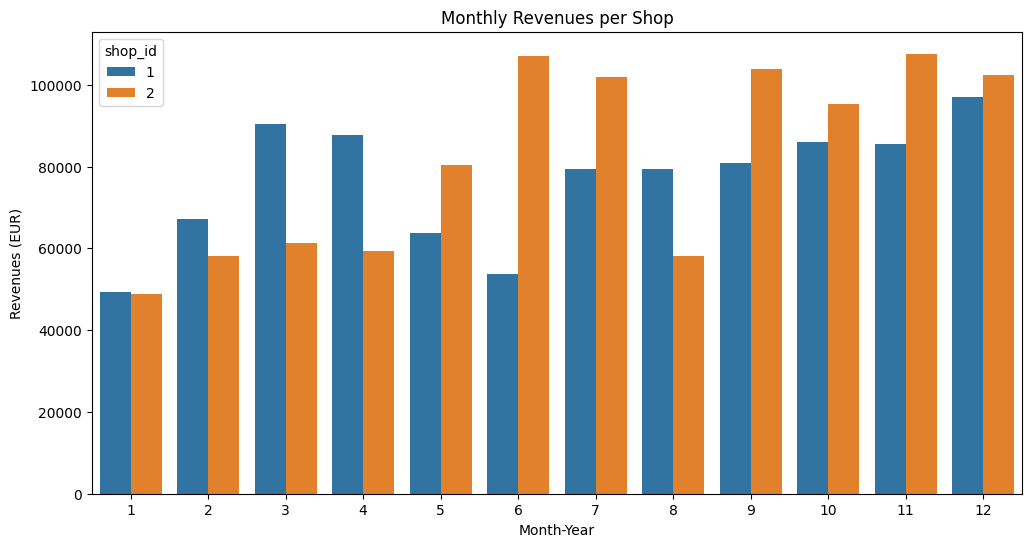

In [18]:
# plotting monthly revenues
plt.figure(figsize=(12, 6))
line_plot = sns.barplot(x='month', y='revenue_per_month', hue='shop_id', data=monthly_revenue_df)
line_plot.set_title('Monthly Revenues per Shop')
line_plot.set_xlabel('Month-Year')
line_plot.set_ylabel('Revenues (EUR)')
plt.show()

<Figure size 1200x600 with 0 Axes>

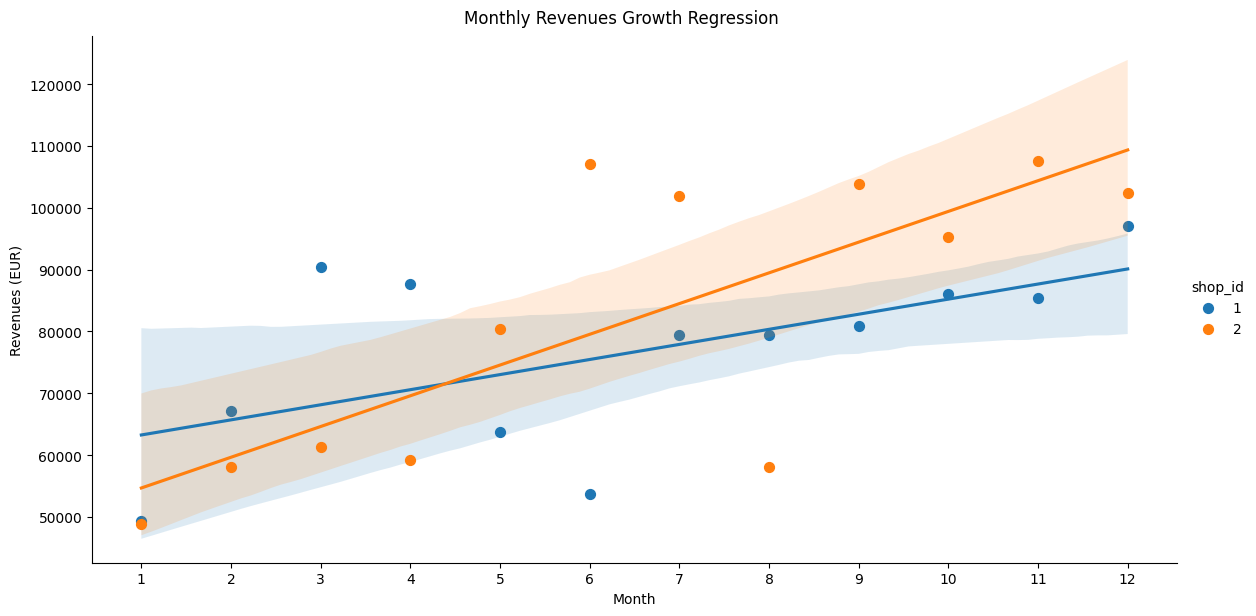

In [19]:
#Linear regression on monthly revenues of shop 1 and 2
plt.figure(figsize=(12, 6))
scatter_plot = sns.lmplot(x='month', y='revenue_per_month', hue='shop_id', data=monthly_revenue_df, height=6, aspect=2, x_estimator=np.mean)
plt.xticks(monthly_revenue_df['month'].unique())
scatter_plot.set_axis_labels('Month', 'Revenues (EUR)')
scatter_plot.fig.suptitle('Monthly Revenues Growth Regression', y=1.02)
plt.show();

*Note: we observe continuous positive growth in both shops' revenue*

## Revenue Forecasting

<Figure size 1200x600 with 0 Axes>

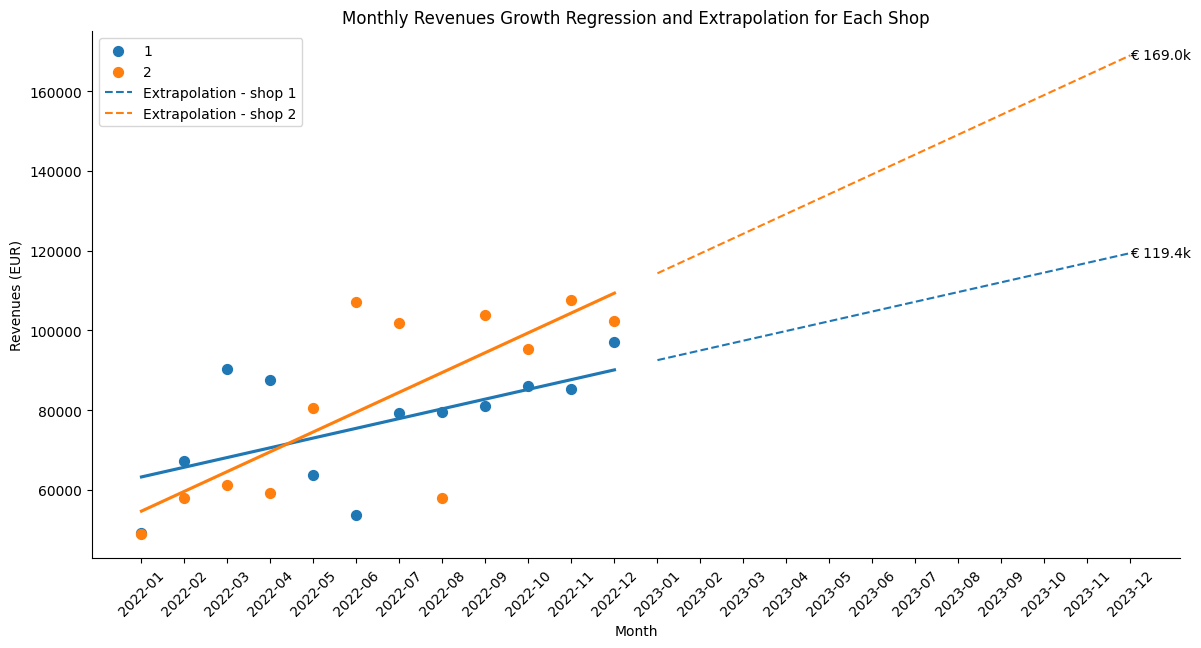

In [20]:
# Visualizing extrapolation of shop 1 and 2 monthly revenues to 2023

plt.figure(figsize=(12, 6))

revenue_extrapolation_df = pd.DataFrame(columns=['month', 'shop_id', 'extrapolated_revenue'])
scatter_plot = sns.lmplot(x='month', y='revenue_per_month', hue='shop_id', data=monthly_revenue_df, \
                          height=6, aspect=2, x_estimator=np.mean, ci=None, legend=False)

for shop_id in monthly_revenue_df['shop_id'].unique():
    shop_data = monthly_revenue_df[monthly_revenue_df['shop_id'] == shop_id]
    x_values = shop_data['month']
    y_values = shop_data['revenue_per_month']
    coefficients = np.polyfit(x_values, y_values, 1)
    poly = np.poly1d(coefficients)
    next_months = np.arange(13, 25, 1)
    extrapolated_values = poly(next_months)
    plt.plot(next_months, extrapolated_values, label=f'Extrapolation - shop {shop_id}', linestyle='--')
    rounded_value_in_k = round(extrapolated_values[-1] / 1000, 1)
    plt.text(next_months[-1], extrapolated_values[-1], '€ {}k'.format(rounded_value_in_k), ha='left', va='center')
    extrapolation_data = pd.DataFrame({'month': next_months, 'shop_id': shop_id, 'extrapolated_revenue': extrapolated_values})
    revenue_extrapolation_df = pd.concat([revenue_extrapolation_df, extrapolation_data], ignore_index=True)

plt.xlabel('Month')
plt.ylabel('Revenues (EUR)')
plt.title('Monthly Revenues Growth Regression and Extrapolation for Each Shop')
plt.xticks(np.arange(1, 25), ['2022-{:02d}'.format(month) for month in range(1, 13)] + \
           ['2023-{:02d}'.format(month) for month in range(1, 13)], rotation=45)

plt.legend()
plt.show();

<Figure size 1200x600 with 0 Axes>

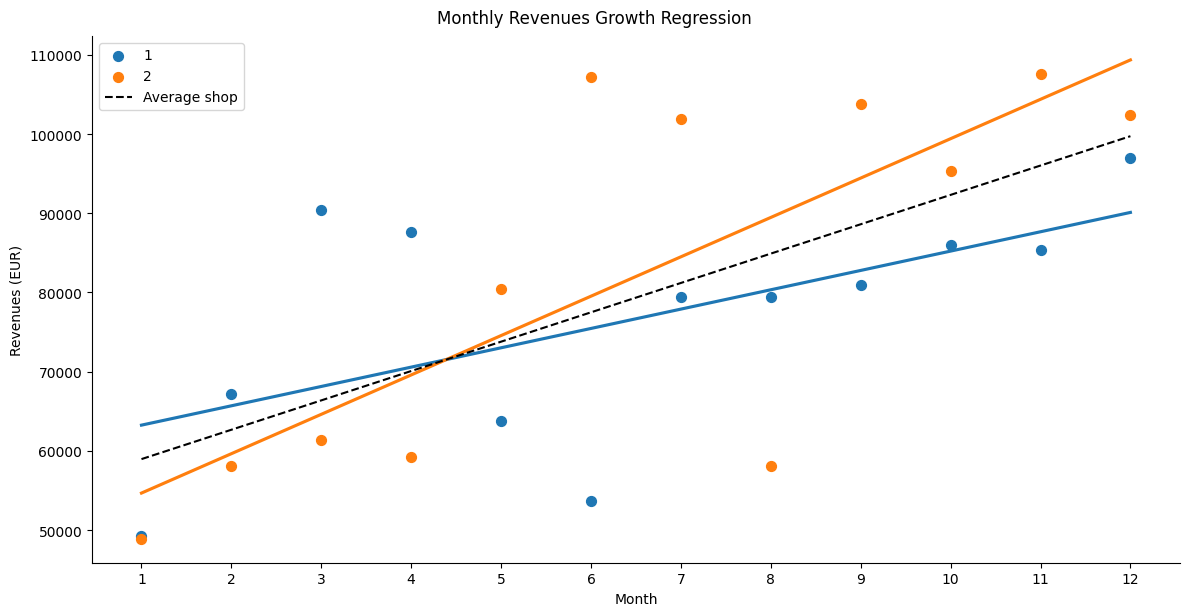

In [21]:
# Approximating the monthly revenue of a new shop as an average of shop 1 and 2

plt.figure(figsize=(12, 6))

monthly_revenue_df['month'] = pd.to_numeric(monthly_revenue_df['month'], errors='coerce')
scatter_plot = sns.lmplot(x='month', y='revenue_per_month', hue='shop_id', data=monthly_revenue_df,
                          height=6, aspect=2, x_estimator=np.mean, ci=None, legend=False)

average_line_data = monthly_revenue_df.groupby('month')['revenue_per_month'].mean().reset_index()
coefficients = np.polyfit(average_line_data['month'], average_line_data['revenue_per_month'], 1)
poly = np.poly1d(coefficients)
plt.plot(average_line_data['month'], poly(average_line_data['month']), label='Average shop', linestyle = '--',color='black')
plt.xticks(monthly_revenue_df['month'].unique())
scatter_plot.set_axis_labels('Month', 'Revenues (EUR)')
scatter_plot.fig.suptitle('Monthly Revenues Growth Regression', y=1.02)

plt.legend()
plt.show()

average_shop_revenue_regression = pd.DataFrame({
    'month': average_line_data['month'],
    'revenue_per_month': poly(average_line_data['month'])})

### Revenue estimates for shop 3 and 4

Estimation approach:
- shop 3 and shop 4 start operating in March 2023 and July 2023 respectively
- Considering shop 3 and 4 to behave as the regression average of shop 1 and 2 in 2022
- shop 3 will inhirit the first 10 months and shop 4 the first 6 months of the average regression points

In [22]:
#calculating shop3 and 4 monthly revenues
shop_3_data = average_shop_revenue_regression.head(10).copy()
shop_3_data['shop_id'] = 3
shop_3_data['month'] = np.arange(3, 13)

shop_4_data = average_shop_revenue_regression.head(6).copy()
shop_4_data['shop_id'] = 4
shop_4_data['month'] = np.arange(7, 13)

new_shops_df = pd.concat([shop_3_data, shop_4_data], ignore_index=True)
new_shops_df['revenue_per_month']=new_shops_df.revenue_per_month.round()
new_shops_df

,month,revenue_per_month,shop_id
0,3,58959.0,3
1,4,62665.0,3
2,5,66372.0,3
3,6,70078.0,3
4,7,73785.0,3
5,8,77491.0,3
6,9,81198.0,3
7,10,84905.0,3
8,11,88611.0,3
9,12,92318.0,3


<Figure size 1200x600 with 0 Axes>

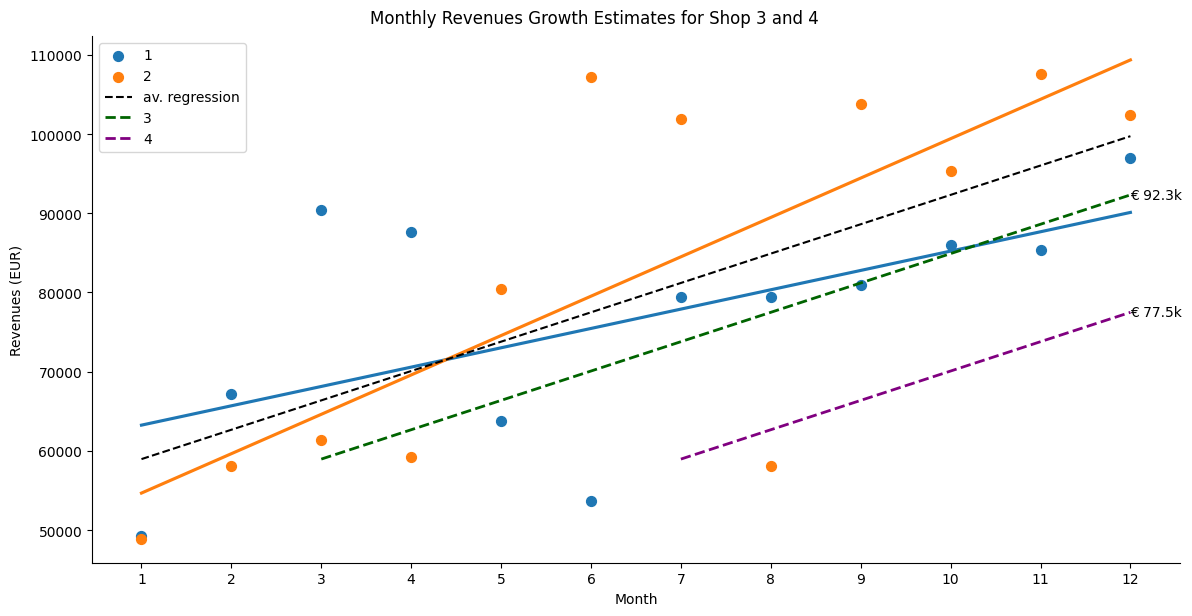

In [23]:
# Visualization of 2023 esimate revenues for shop 3 and 4

plt.figure(figsize=(12, 6))

monthly_revenue_df['month'] = pd.to_numeric(monthly_revenue_df['month'], errors='coerce')
scatter_plot = sns.lmplot(x='month', y='revenue_per_month', hue='shop_id', data=monthly_revenue_df,
                          height=6, aspect=2, x_estimator=np.mean, ci=None, legend=False)
average_line_data = monthly_revenue_df.groupby('month')['revenue_per_month'].mean().reset_index()
coefficients = np.polyfit(average_line_data['month'], average_line_data['revenue_per_month'], 1)
poly = np.poly1d(coefficients)
plt.plot(average_line_data['month'], poly(average_line_data['month']), label='av. regression', linestyle='--', color='black')
plt.xticks(monthly_revenue_df['month'].unique())

for shop_id in new_shops_df['shop_id'].unique():
    shop_data = new_shops_df[new_shops_df['shop_id'] == shop_id]
    coefficients_new = np.polyfit(shop_data['month'], shop_data['revenue_per_month'], 1)
    poly_new = np.poly1d(coefficients_new)
    line_color = 'darkgreen' if shop_id == 3 else 'purple' if shop_id == 4 else 'green'
    line_style = '--' if shop_id in [3, 4] else '-'
    line_width = 2 if shop_id in [3, 4] else 1
    plt.plot(shop_data['month'], poly_new(shop_data['month']), label=shop_id, linestyle=line_style, color=line_color, linewidth=line_width)
    if shop_id in [3, 4]:
        end_point_value = poly_new(shop_data['month'].max())
        rounded_value_in_k = round(end_point_value / 1000, 1)
        plt.text(shop_data['month'].max(), end_point_value, '€ {}k'.format(rounded_value_in_k), ha='left', va='center')


scatter_plot.set_axis_labels('Month', 'Revenues (EUR)')
scatter_plot.fig.suptitle('Monthly Revenues Growth Estimates for Shop 3 and 4', y=1.02)


plt.legend()
plt.show();

### Calculating estimated total revenues in 2023

In [24]:
# Etrapolated revenues for shop 1 and 2 in 2023
est_2023_revenue_shop_1_2 = revenue_extrapolation_df['extrapolated_revenue'].sum().round()
est_2023_revenue_shop_1_2

2971769.0

In [25]:
est_2023_revenue_shop_3_4 = new_shops_df['revenue_per_month'].sum().round()
est_2023_revenue_shop_3_4

1165732.0

In [26]:
est_total_2023_revenue = est_2023_revenue_shop_1_2 + est_2023_revenue_shop_3_4
est_total_2023_revenue

4137501.0

## Tracking New customers

In [27]:
# Identifying new customers
merged_df['new_customer'] = ~merged_df.duplicated('customer_id', keep='first')
merged_df.tail()

,order_id,seller_id,customer_id,shop_id,order_date,revenues,month,new_customer
10197,ec57c865-4038-438c-947d-2b54265c2010,2ea0ca2a-77fc-4447-b57c-62a6cb4d75a1,89593,1,2022-12-31,466.06,12,False
9876,e48bd3e1-3a23-42ad-aec0-9f9cdc1568a5,45baf1d2-e066-4f40-8fc5-c61c08d4af4c,91816,1,2022-12-31,82.44,12,True
2050,2e76599d-7675-4cd2-a082-c23fa56eacbd,45baf1d2-e066-4f40-8fc5-c61c08d4af4c,89370,1,2022-12-31,244.95,12,False
8289,bfd2d7ff-34f6-4f66-b464-6dea6a4ccffc,45baf1d2-e066-4f40-8fc5-c61c08d4af4c,91833,1,2022-12-31,75.37,12,True
4368,64752c43-3b4b-478a-92c3-31f6e118813c,098431c3-1301-456e-9171-0026d20a3d62,24008,1,2022-12-31,21.20,12,False


In [28]:
# total number of unique customers that visited both shops in 2022
merged_df.customer_id.nunique()

3977

In [29]:
# Calculating monthly new customers per shop
new_customers_by_shop_month = merged_df.groupby(['shop_id', 'month'])['new_customer'].sum().reset_index()
new_customers_by_shop_month

,shop_id,month,new_customer
0,1,1,260
1,1,2,114
2,1,3,102
3,1,4,126
4,1,5,142
5,1,6,94
6,1,7,125
7,1,8,150
8,1,9,134
9,1,10,109


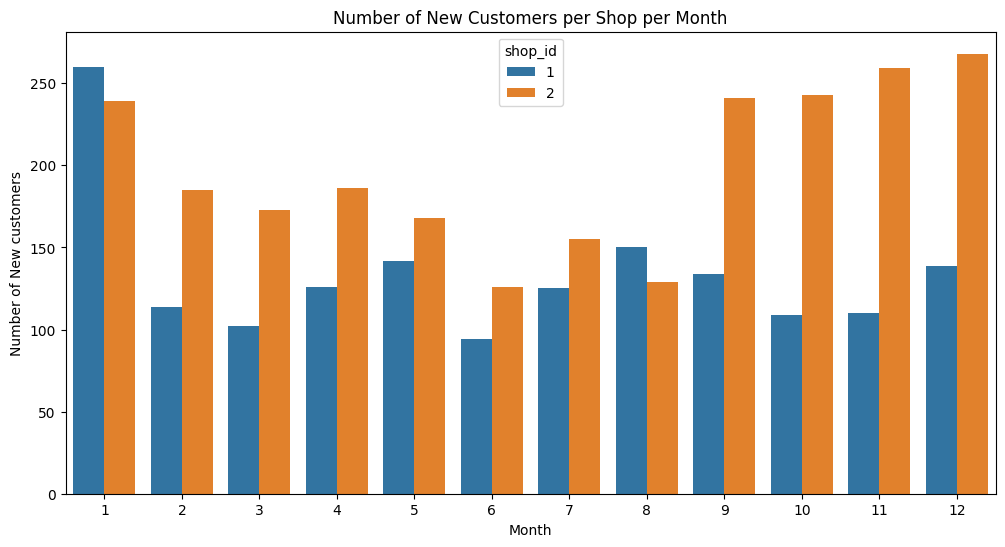

In [30]:
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='month', y='new_customer', hue='shop_id', data=new_customers_by_shop_month)
bar_plot.set_title('Number of New Customers per Shop per Month')
bar_plot.set_xlabel('Month')
bar_plot.set_ylabel('Number of New customers');

*Both shops received approximately 250 new customers in the first month.*
*shop 2 exhibits a substantial increase in new customers in Q4 while shop 1 shows a steady number of new customers across the year.*

New customers Assumption:
- Based on this observation, we can assume that a new shop would receive an average of 250 new customers in the first month
- Since there is no common clear pattern observed between both shops, an assumption is made that the new shop will receive in the consecutive months a number of new customers that is equal to the monthly arithmetic average of shop 1 and 2 from February to December

In [31]:
monthly_new_customers_average_shop = new_customers_by_shop_month.groupby('month')['new_customer'].mean().reset_index()
monthly_new_customers_average_shop

,month,new_customer
0,1,249.5
1,2,149.5
2,3,137.5
3,4,156.0
4,5,155.0
5,6,110.0
6,7,140.0
7,8,139.5
8,9,187.5
9,10,176.0


### Estimating customers numbers in 2023

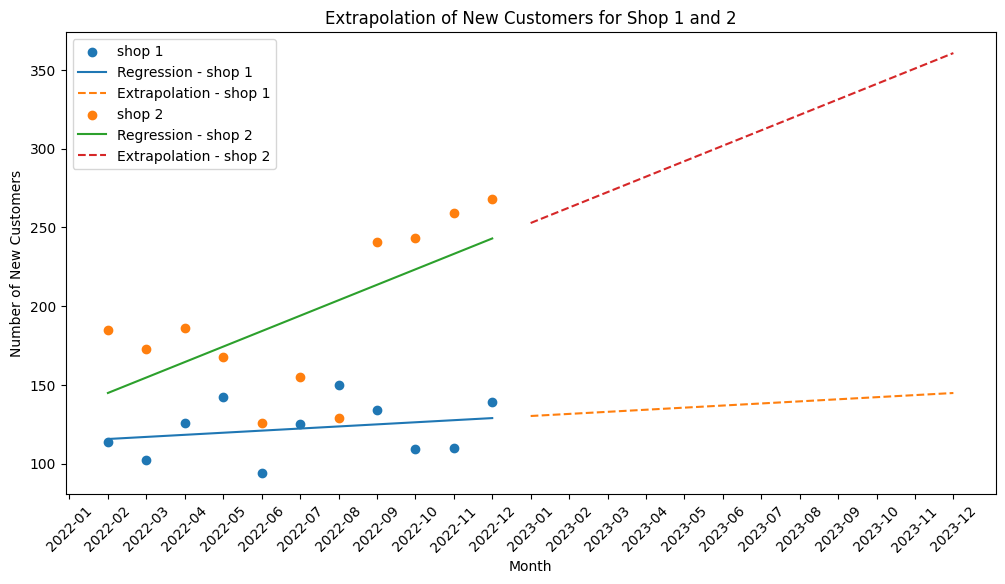

In [32]:
# Plotting linear regression for monthly new employees in each shop and extrapolating to 2023

new_customer_regression_data = new_customers_by_shop_month[new_customers_by_shop_month['month'] != 1]
new_customers_extrapolation_data = pd.DataFrame(columns=['shop_id', 'month', 'extrapolated_new_customer'])
plt.figure(figsize=(12, 6))

for shop_id in new_customer_regression_data['shop_id'].unique():
    shop_subset = new_customer_regression_data[new_customer_regression_data['shop_id'] == shop_id]  
    plt.scatter(shop_subset['month'], shop_subset['new_customer'], label=f'shop {shop_id}')
    x_values = shop_subset['month']
    y_values = shop_subset['new_customer']
    coefficients = np.polyfit(x_values, y_values, 1)
    poly = np.poly1d(coefficients)
    plt.plot(x_values, poly(x_values), label=f'Regression - shop {shop_id}')
    next_months = np.arange(13, 25, 1)
    extrapolated_values = poly(next_months)
    plt.plot(next_months, extrapolated_values, label=f'Extrapolation - shop {shop_id}', linestyle='--')
    extrapolation_data_shop = pd.DataFrame({
        'shop_id': [shop_id] * len(next_months),
        'month': next_months,
        'extrapolated_new_customer': extrapolated_values})
    new_customers_extrapolation_data = pd.concat([new_customers_extrapolation_data, extrapolation_data_shop], ignore_index=True).round()

plt.xlabel('Month')
plt.ylabel('Number of New Customers')
plt.title('Extrapolation of New Customers for Shop 1 and 2')

plt.xticks(np.arange(1, 25), ['2022-{:02d}'.format(month) for month in range(1, 13)] + \
           ['2023-{:02d}'.format(month) for month in range(1, 13)], rotation=45)

plt.legend()
plt.show()

In [33]:
new_customers_extrapolation_data

,shop_id,month,extrapolated_new_customer
0,1,13,130.0
1,1,14,132.0
2,1,15,133.0
3,1,16,134.0
4,1,17,136.0
5,1,18,137.0
6,1,19,138.0
7,1,20,140.0
8,1,21,141.0
9,1,22,142.0


In [34]:
#tracking new customers for shop 1 and 2 in 2022
new_customers_2022_shop_1_2 = merged_df.customer_id.nunique()
new_customers_2022_shop_1_2

3977

In [35]:
#estimating new customers for shop 1 and 2 in 2023
est_new_customers_2023_shop_1_2 = new_customers_extrapolation_data['extrapolated_new_customer'].sum()
est_new_customers_2023_shop_1_2

5333.0

In [36]:
#estimating new customers for shop 3 (10 months) and 2 (6 months) in 2023
est_new_customers_2023_shop_3 = monthly_new_customers_average_shop[monthly_new_customers_average_shop['month'].isin(range(0, 11))]
est_new_customers_2023_shop_4 = monthly_new_customers_average_shop[monthly_new_customers_average_shop['month'].isin(range(0, 7))]
est_new_customers_2023_shop_3_4 = est_new_customers_2023_shop_3['new_customer'].sum() + est_new_customers_2023_shop_4['new_customer'].sum()
est_new_customers_2023_shop_3_4

2558.0

In [37]:
# total new customers in 2023 in the 4 shops
est_total_new_customers_2023 = est_new_customers_2023_shop_1_2 + est_new_customers_2023_shop_3_4
est_total_new_customers_2023

7891.0

In [38]:
# combined new customers in 2022 and 2023
total_new_customers_2022_2023 = new_customers_2022_shop_1_2 + est_total_new_customers_2023
total_new_customers_2022_2023

11868.0

## Results Summary

- Revenues for shop 1 and 2 in 2023 are estimated at € 2,971.7k
- Revenues for the planned shop 3 and 4 in 2023 are estimated at € 1,165.7k
- The total customer base of the 4 shops over 2022 and 2023 is estimated to reach 11.9k customer
- Total 2023 revenues from the 4 shops are estimated at **€ 4,137.5k**
- An estimate of **7.9k** new customers are expected to sign up in the 4 shops during 2023
